# AWS Forecast Walk-Through

## Background

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States that coordinates the movement of wholesale electricity in all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia. 

Accurately forecasting load demand is important to PJM's operation because allows them to properly optimize their network, price services, and plan resources. In this notebook we will walk through the steps of building a prototype AWS application that generates time-series predictions and automatically sends an email of the evaluated forecast to specific users. 

### Set-Up

Before using Amazon Forecast, we need to complete the following steps:
1. Sign Up for AWS
2. Set Up the AWS CLI
3. Set Up Permissions for Amazon Forecast
4. Build Environment
    - Deploy a CloudFormation template that will create an S3 bucket for data storage
    - Create SageMaker Notebook Instance where the exercises are executed
    - Set IAM policies for the Notebook Instance
 
Once that is complete we can begin developing in Python:

In [1]:
import json
import time
import dateutil.parser
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import boto3

Create a variable for the S3 bucket name you created and the region your service is using. I read in my Access Key and Secret Key from a text file, it best practice not to hard-code this information.

In [2]:
bucket_name = 'energyforecast'
region = 'us-east-2'

with open('AK.txt', 'r') as f:
    AKEYS = [line.rstrip() for line in f]
ACCESS_KEY = AKEYS[0]
SECRET_KEY = AKEYS[1]

Initialize a session and ensure that your account can communicate with Amazon Forecast

In [3]:
session = boto3.Session(region_name=region, aws_access_key_id = ACCESS_KEY, aws_secret_access_key = SECRET_KEY) 
forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')

In [4]:
# Create and define function to upload files to AWS - will be used later on
def upload_to_aws(local_file, bucket, s3_file):
    s3 = boto3.client('s3', aws_access_key_id=ACCESS_KEY,
                      aws_secret_access_key=SECRET_KEY)
    try:
        s3.upload_file(local_file, bucket, s3_file)
        print("Upload Successful")
        return True
    except FileNotFoundError:
        print("The file was not found")
        return False

## Preparing the Data

In [5]:
energy_df = pd.read_csv("pjm_hourly_est.csv", dtype = object, header=0)
energy_df.head(3)

,timestamp,usage,client_id
0,2014-01-01 01:00:00,11562,COMED
1,2014-01-01 01:00:00,11481,DOM
2,2014-01-01 01:00:00,7340,FE


There are the 3 key pieces of information required to generate a forecast with Amazon Forecast: the timestamp, a value, and an item. More can be added but these 3 must always remain present.

In our case the value is the energy usage and item is the client.  The data set is from January 1st, 2014 to August 2nd, 2018. We will train the model using all the data and make predictions for the next 48 hours.

In [6]:
# Select dates before 2018-08-01 to train the model
train_data = energy_df[(energy_df['timestamp'] <= '2018-08-02')]

# Export to data folder
train_data.to_csv("data/energyforecast-train.csv", header=False, index=False)

Using the pre-defined function we created earlier, we upload the training data to our S3 bucket. We pass the argument for the local file name to be the same in the S3 bucket.

In [7]:
# Send and load data to S3 bucket
file_name="data/energyforecast-train.csv"

upload_to_aws(file_name, bucket_name, file_name)

Upload Successful


True

#### Creating the Dataset Group and Dataset
In Amazon Forecast , a dataset is a collection of file(s) which contain data that is relevant for a forecasting task. A dataset must conform to a schema provided by Amazon Forecast.

For this example, we are using CUSTOM domain with 3 required attributes: timestamp, target_value and item_id.

In [8]:
# Convey how Amazon Forecast can understand your time-series information
DATASET_FREQUENCY = "H" 
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"

 Configure variable names for the Project, Dataset Group, and Dataset.

In [9]:
project = 'energy_forecast'
datasetName= project+'_ds'
datasetGroupName= project +'_dsg'
s3DataPath = "s3://"+bucket_name+"/"+file_name

Create the dataset group using the CUSTOM domain

In [10]:
create_dataset_group_response = forecast.create_dataset_group(DatasetGroupName=datasetGroupName, Domain="CUSTOM")
datasetGroupArn = create_dataset_group_response['DatasetGroupArn']

forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)

{'DatasetGroupName': 'energy_forecast_dsg',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-2:120526968543:dataset-group/energy_forecast_dsg',
 'DatasetArns': [],
 'Domain': 'CUSTOM',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 4, 16, 19, 31, 6, 5000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 4, 16, 19, 31, 6, 5000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'dca666fb-7ee8-4a64-9bf2-10786b1c0a7e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 16 Apr 2020 23:31:05 GMT',
   'x-amzn-requestid': 'dca666fb-7ee8-4a64-9bf2-10786b1c0a7e',
   'content-length': '261',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

Define the schema.

In [11]:
# Make sure the order of columns matches the raw data files.
schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }
   ]
}

Create the dataset and define the appropriate parameters.

In [12]:
response=forecast.create_dataset(
                    Domain="CUSTOM",
                    DatasetType='TARGET_TIME_SERIES',
                    DatasetName=datasetName,
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = schema)

datasetArn = response['DatasetArn']

Now we need to add the dataset to the dataset group.

In [13]:
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[datasetArn])

{'ResponseMetadata': {'RequestId': '93f09d70-6ac8-4ec0-b71a-b11dec82e49a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 16 Apr 2020 23:31:05 GMT',
   'x-amzn-requestid': '93f09d70-6ac8-4ec0-b71a-b11dec82e49a',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

#### Create IAM Role for Forecast

In [14]:
iam = boto3.client("iam", aws_access_key_id = ACCESS_KEY, aws_secret_access_key = SECRET_KEY)

role_name = "ForecastRole"
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "forecast.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

try:
    create_role_response = iam.create_role(
        RoleName = role_name,
        AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
    )
    role_arn = create_role_response["Role"]["Arn"]
except iam.exceptions.EntityAlreadyExistsException:
    print("The role " + role_name + " exists, ignore to create it")
    role_arn = boto3.resource('iam').Role(role_name).arn
    
# Attaching AmazonForecastFullAccess to access all actions for Amazon Forecast
policy_arn = "arn:aws:iam::aws:policy/AmazonForecastFullAccess"
iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = policy_arn
)

# Now add S3 support
iam.attach_role_policy(
    PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
    RoleName=role_name
)
time.sleep(60) # wait for a minute to allow IAM role policy attachment to propagate

print(role_arn)

arn:aws:iam::120526968543:role/ForecastRole


#### Data Import: From S3 to Amazon Forecast

In [15]:
datasetImportJobName = 'E_DSIMPORT_JOB_TARGET'
ds_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                          DatasetArn=datasetArn,
                                                          DataSource= {
                                                              "S3Config" : {
                                                                 "Path":s3DataPath,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          },
                                                          TimestampFormat=TIMESTAMP_FORMAT
                                                         )
ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)

arn:aws:forecast:us-east-2:120526968543:dataset-import-job/energy_forecast_ds/E_DSIMPORT_JOB_TARGET


The data import can take anywhere from 5 to 10 min depending on the size of the data so we will create a while loop to check on the status - once the job is complete the loop will break and let us know the data is active

In [16]:
status = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
while True:
    status = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

print(status)

ACTIVE


## Build and Evaluate the Model


### Create Predictor
First thing we need to do is set a few parameters. Forecast horizon is the number of number of time points to predicted in the future. For weekly data, a value of 12 means 12 weeks. Our example is hourly data and we want the forecast for the next two days so we set the horizon to 48.

We will use the pre-built Deep AR+ model. The Amazon SageMaker DeepAR forecasting algorithm is a supervised learning algorithm for forecasting scalar (one-dimensional) time series using recurrent neural networks (RNN).

In [17]:
predictorName= project+'_deeparp'
forecastHorizon = 48
algorithmArn = 'arn:aws:forecast:::algorithm/Deep_AR_Plus'

Now we send the API call to create the predictor.  Depending on data size, model selection and hyper parameters, it can take 10 mins to more than one hour to be active, so we will create a while loop to check on the status and let us know when the process is complete.

In [18]:
create_predictor_response=forecast.create_predictor(PredictorName=predictorName, 
                                                  AlgorithmArn=algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": 1, 
                                                                         "BackTestWindowOffset": forecastHorizon}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn},
                                                  FeaturizationConfig= {"ForecastFrequency": "H", 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )
predictor_arn=create_predictor_response['PredictorArn']

status = forecast.describe_predictor(PredictorArn=predictor_arn)['Status']
while True:
    status = forecast.describe_predictor(PredictorArn=predictor_arn)['Status']
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

print(status)

ACTIVE


Evaluate the model's accuracy

In [19]:
forecast.get_accuracy_metrics(PredictorArn=predictor_arn)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 1172.9397066773354,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.027967853610062154},
       {'Quantile': 0.5, 'LossValue': 0.0925880627293065},
       {'Quantile': 0.1, 'LossValue': 0.09051045400235201}]}},
    {'TestWindowStart': datetime.datetime(2018, 7, 30, 20, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2018, 8, 1, 20, 0, tzinfo=tzlocal()),
     'ItemCount': 3,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 1172.9397066773354,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.027967853610062154},
       {'Quantile': 0.5, 'LossValue': 0.0925880627293065},
       {'Quantile': 0.1, 'LossValue': 0.09051045400235201}]}}]}],
 'ResponseMetadata': {'RequestId': 'fe23b698-135a-42fe-a0b0-709c961ea828',
  'HTTPStatusCode': 200,
  'HTTPHeaders'

### Create a Forecast

In [20]:
forecastName= project+'_deeparp_algo_forecast'
create_forecast_response=forecast.create_forecast(ForecastName=forecastName,
                                                  PredictorArn=predictor_arn)
forecast_arn = create_forecast_response['ForecastArn']

Check the status of the forecast process- similar to the predictor - it can take 10 mins to more than one hour to be active.

In [21]:
status = forecast.describe_forecast(ForecastArn=forecast_arn)['Status']
while True:
    status = forecast.describe_forecast(ForecastArn=forecast_arn)['Status']
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

print(status)

ACTIVE


## Evaluating the Forecast

We use the Amazon QueryForecast to view the results of our forecast. Using the 'Filters' variable allows the capability to choose the specific client we want to analyze.

In [22]:
print(forecast_arn)
forecastResponse = forecastquery.query_forecast(
    ForecastArn=forecast_arn,
    Filters={"item_id":"COMED"})

print(forecastResponse)

arn:aws:forecast:us-east-2:120526968543:forecast/energy_forecast_deeparp_algo_forecast
{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2018-08-02T00:00:00', 'Value': 12508.5244140625}, {'Timestamp': '2018-08-02T01:00:00', 'Value': 11628.548828125}, {'Timestamp': '2018-08-02T02:00:00', 'Value': 10934.3720703125}, {'Timestamp': '2018-08-02T03:00:00', 'Value': 10405.2119140625}, {'Timestamp': '2018-08-02T04:00:00', 'Value': 10016.732421875}, {'Timestamp': '2018-08-02T05:00:00', 'Value': 9817.533203125}, {'Timestamp': '2018-08-02T06:00:00', 'Value': 9817.103515625}, {'Timestamp': '2018-08-02T07:00:00', 'Value': 10432.658203125}, {'Timestamp': '2018-08-02T08:00:00', 'Value': 11086.9609375}, {'Timestamp': '2018-08-02T09:00:00', 'Value': 12137.33203125}, {'Timestamp': '2018-08-02T10:00:00', 'Value': 12765.474609375}, {'Timestamp': '2018-08-02T11:00:00', 'Value': 13366.68359375}, {'Timestamp': '2018-08-02T12:00:00', 'Value': 14096.6982421875}, {'Timestamp': '2018-08-02T13:00:00', 'Value':

Create a loop to extract forecasts for each client/item and store in separate data frames with actuals.

In [27]:
results_dict = {}
for client in energy_df['client_id'].unique():
    forecastResponse = forecastquery.query_forecast(ForecastArn=forecast_arn, Filters={"item_id":str(client)})
    timestamp = [forecastResponse['Forecast']['Predictions']['p10'][i]['Timestamp'] for i in range(forecastHorizon)]
    prediction_p10 = np.array([forecastResponse['Forecast']['Predictions']['p10'][i]['Value'] for i in range(forecastHorizon)])
    prediction_p50 = np.array([forecastResponse['Forecast']['Predictions']['p50'][i]['Value'] for i in range(forecastHorizon)])
    prediction_p90 = np.array([forecastResponse['Forecast']['Predictions']['p90'][i]['Value'] for i in range(forecastHorizon)])
    result = pd.DataFrame({'timestamp':timestamp, 
                           'p10':prediction_p10,
                           'p50':prediction_p50,
                           'p90':prediction_p90
                          })
    results_dict[str(client)] = result

Plot and save the figures

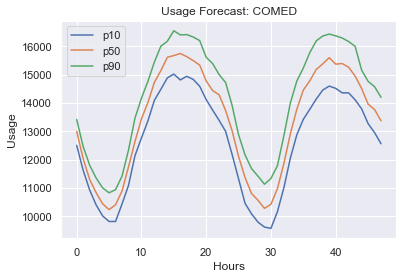

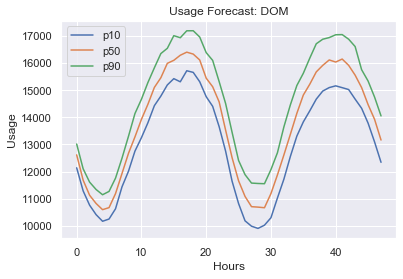

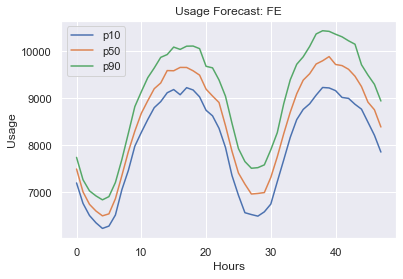

In [28]:
figures = []
for key, value in results_dict.items():
    value.plot()
    plt.xlabel('Hours')
    plt.ylabel('Usage')
    plt.title("Usage Forecast: "+ str(key))
    plt.savefig('plots/usage-forecast_'+key+'.jpeg')
    

## Email The Reports

Import the libraries and authenticate account with AWS SES

In [29]:
import smtplib  
import email.utils
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import os
from email.mime.application import MIMEApplication
from email.mime.image import MIMEImage

# Read in SMTP ID and Password
with open('SMTP.txt', 'r') as f:
    SMTP = [line.rstrip() for line in f]
SMTP_KEY = SMTP[0]
SMTP_PASS = SMTP[1]

# Replace sender@example.com with your "From" address. 
# This address must be verified.
SENDER = 'sender@example.com'  
SENDERNAME = 'Sender Name'

# Replace recipient@example.com with a "To" address. If your account 
# is still in the sandbox, this address must be verified.
RECIPIENT  = 'recipient@example.com'

# Replace smtp_username with your Amazon SES SMTP user name.
USERNAME_SMTP = SMTP_KEY

# Replace smtp_password with your Amazon SES SMTP password.
PASSWORD_SMTP = SMTP_PASS

# (Optional) the name of a configuration set to use for this message.
# If you comment out this line, you also need to remove or comment out
# the "X-SES-CONFIGURATION-SET:" header below.
#CONFIGURATION_SET = "ConfigSet"

# If you're using Amazon SES in an AWS Region other than US West (Oregon), 
# replace email-smtp.us-west-2.amazonaws.com with the Amazon SES SMTP  
# endpoint in the appropriate region.
HOST = "email-smtp.us-east-1.amazonaws.com"
PORT = 587

# The subject line of the email.
SUBJECT = 'Weekly Forecast Report'


Create the body of the E-mail and attach the images of the graphs to the E-mail.

In [30]:

# The HTML body of the email.
BODY_HTML = """<html>
<head></head>
<body>
  <h1>Here is your Report from Amazon Forecast</h1>
  <p> See attached images </p>
</body>
</html>
            """

# Create message container - the correct MIME type is multipart/alternative.
msg = MIMEMultipart('mixed')
msg['Subject'] = SUBJECT
msg['From'] = email.utils.formataddr((SENDERNAME, SENDER))
msg['To'] = RECIPIENT
for client in energy_df['client_id'].unique():
    ATTACHMENT = 'plots/usage-forecast_{0}.jpeg'.format(client)
    att = MIMEApplication(open(ATTACHMENT, 'rb').read())
    att.add_header('Content_disposition','attachment',filename=str(client)+".jpeg")
    msg.attach(att)
# Record the MIME types of both parts - text/plain and text/html.
part1 = MIMEText(BODY_HTML, 'html')

# Attach parts into message container.
# According to RFC 2046, the last part of a multipart message, in this case
# the HTML message, is best and preferred.
msg.attach(part1)

Send the E-mail

In [31]:
# Try to send the message.
try:  
    server = smtplib.SMTP(HOST, PORT)
    server.ehlo()
    server.starttls()
    #stmplib docs recommend calling ehlo() before & after starttls()
    server.ehlo()
    server.login(USERNAME_SMTP, PASSWORD_SMTP)
    server.sendmail(SENDER, RECIPIENT, msg.as_string())
    server.close()
# Display an error message if something goes wrong.
except Exception as e:
    print ("Error: ", e)
else:
    print ("Email sent!")

Email sent!


## Cleanup the Workspace

In [33]:
# Delete the Foreacst:
forecast.delete_forecast(ForecastArn=forecast_arn)
time.sleep(120)
# Delete the Predictor:
forecast.delete_predictor(PredictorArn=predictor_arn)
time.sleep(120)
# Delete Import
forecast.delete_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)
time.sleep(120)
# Delete the Dataset:
forecast.delete_dataset(DatasetArn=datasetArn)
time.sleep(120)
# Delete the DatasetGroup:
forecast.delete_dataset_group(DatasetGroupArn=datasetGroupArn)
time.sleep(120)
# Delete your file in S3
boto3.Session().resource('s3').Bucket(bucket_name).Object(file_name).delete()
time.sleep(120)

The very last step in the notebooks is to remove the policies that were attached to a role and then to delete it. No changes should need to be made here, just execute the cell.

In [34]:
# IAM policies should also be removed
iam = boto3.client("iam")
iam.detach_role_policy(PolicyArn="arn:aws:iam::aws:policy/AmazonS3FullAccess", RoleName=role_name)
iam.detach_role_policy(PolicyArn="arn:aws:iam::aws:policy/AmazonForecastFullAccess",RoleName=role_name)

iam.delete_role(RoleName=role_name)

{'ResponseMetadata': {'RequestId': '1f9a29d8-13e7-4a95-a6c1-82ef29ac5a0c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '1f9a29d8-13e7-4a95-a6c1-82ef29ac5a0c',
   'content-type': 'text/xml',
   'content-length': '200',
   'date': 'Fri, 17 Apr 2020 01:33:30 GMT'},
  'RetryAttempts': 0}}